# DCGAN with Regularization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


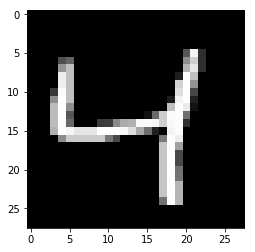

In [3]:
img = mnist.train.images[2]
img = img.reshape((28, 28))
plt.imshow(img, cmap="Greys_r")
plt.show()

In [4]:
def Discriminator_Regularizer(D1_logits, D1_arg, D2_logits, D2_arg, batch_size):
    D1 = tf.nn.sigmoid(D1_logits)
    D2 = tf.nn.sigmoid(D2_logits)
    grad_D1_logits = tf.gradients(D1_logits, D1_arg)[0]
    grad_D2_logits = tf.gradients(D2_logits, D2_arg)[0]
    grad_D1_logits_norm = tf.norm(tf.reshape(grad_D1_logits, [batch_size,-1]), axis=1, keep_dims=True)
    grad_D2_logits_norm = tf.norm(tf.reshape(grad_D2_logits, [batch_size,-1]), axis=1, keep_dims=True)

    #set keep_dims=True/False such that grad_D_logits_norm.shape == D.shape
    print(grad_D1_logits_norm.shape)
    print(D1.shape)
    assert grad_D1_logits_norm.shape == D1.shape
    assert grad_D2_logits_norm.shape == D2.shape

    reg_D1 = tf.multiply(tf.square(1.0-D1), tf.square(grad_D1_logits_norm))
    reg_D2 = tf.multiply(tf.square(D2), tf.square(grad_D2_logits_norm))
    disc_regularizer = tf.reduce_mean(reg_D1 + reg_D2)
    return disc_regularizer

In [5]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def conv2d(x, W_size, name, strides=[1, 1, 1, 1]):
    """
    make conv layer
    
    :param x: input to conv layer. the size must match with W_size. 
    :param W_size: list. [filter_width, filter_height, input_channel, output_channel]
    :param strides: list of strides of each dimension as follows. [batch, width, height, channel] 
    :return: returns conv layer with bias b added. 
    """
    W = tf.get_variable(shape=W_size, name=name+"/weight")
    b = tf.get_variable(shape=W_size[3], name=name+"/bias")
    conv = tf.nn.conv2d(input=x, filter=W, strides=strides, padding="SAME")
    return conv + b

In [6]:
def initialize_inputs_gamma(x_size, z_size):
    """
    initialize inputs x and z. 
    
    x is for real data, and z is for random noise for generator. 
    
    :param z_size: size of z vector
    :return x and z 
    """
    x = tf.placeholder(dtype=tf.float32, shape=[batch_size, *x_size], name="input_real")
    z = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_size], name="input_z")
    gamma = tf.placeholder(dtype=tf.float32, shape=None, name="gamma")
    
    return x, z, gamma

In [7]:
def generator(z, z_size, reuse=False, training=True):
    """
    :param z: a vector with length z_size, where every elements of z is between -1 and 1
    :param z_size: length of the z vector
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates generator and return the logits and model
    """
    with tf.variable_scope("generator", reuse=reuse):
        # layer 1: fully connected layer 
        # change the length of z such that it fits to conv layer 
        W_fc1 = tf.get_variable(shape=[z_size, 7*7*256], name="fc_weight")
        b_fc1 = tf.get_variable(shape=7*7*256, name="fc_bias")
        h_fc1 = tf.matmul(z, W_fc1) + b_fc1
        # now, (7*7*256, )

        # layer 2: reshape layer 
        reshape2 = tf.reshape(h_fc1, shape=[-1, 7, 7, 256])
        # now, 7 x 7 x 256
        batch_norm2 = tf.layers.batch_normalization(reshape2, training=training)
        relu2 = leaky_relu(batch_norm2)

        # layer 3: conv layer 
        resize3 = tf.image.resize_nearest_neighbor(images=relu2, size=(14, 14))
        # now, 14 x 14 x 256
        conv3 = conv2d(x=resize3, W_size=[5, 5, 256, 128], name="conv3")
        # now, 14 x 14 x 128
        batch_norm3 = tf.layers.batch_normalization(conv3, training=training)
        relu3 = leaky_relu(batch_norm3)

        # layer 4: conv layer 
        resize4 = tf.image.resize_nearest_neighbor(images=relu3, size=(28, 28))
        # now, 28 x 28 x 128
        conv4 = conv2d(x=resize4, W_size=[5, 5, 128, 64], name="conv4")
        # now, 28 x 28 x 64
        batch_norm4 = tf.layers.batch_normalization(conv4, training=training)
        relu4 = leaky_relu(batch_norm4)
        
        # layer 5: conv layer 
        conv5 = conv2d(x=relu4, W_size=[5, 5, 64, 32], name="conv5")
        # now, 28 x 28 x 32
        batch_norm5 = tf.layers.batch_normalization(conv5, training=training)
        relu5 = leaky_relu(batch_norm5)
        
        # layer 5: output layer 
        logits = conv2d(x=relu5, W_size=[5, 5, 32, 1], name="output")
        model = tf.tanh(logits)
        
        return logits, model

In [8]:
def discriminator(x, reuse=False, training=True):
    """
    :param x: list [None, 28, 28, 1], where every element is between -1 and 1
    :param reuse: boolean. whether to reuse the trained variable of weights. 
    :param training: boolean. whether it is training or not
    :return: creates discriminator and returns logits and model 
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # layer 0: conv layer 
        conv0 = conv2d(x=x, W_size=[5, 5, 1, 32], strides=[1, 2, 2, 1], name="conv0")
        # now, 14 x 14 x 32
        relu0 = leaky_relu(conv0)
        
        # layer 1: conv layer 
        conv1 = conv2d(x=relu0, W_size=[5, 5, 32, 64], strides=[1, 2, 2, 1], name="conv1")
        # now, 7 x 7 x 64
        relu1 = leaky_relu(conv1)
        
        # layer 2: conv layer 
        conv2 = conv2d(x=relu1, W_size=[5, 5, 64, 128], strides=[1, 2, 2, 1], name="conv2")
        # now, 4 x 4 x 128
        batch_norm2 = tf.layers.batch_normalization(conv2, training=training)
        relu2 = leaky_relu(batch_norm2)
        
        # layer 3: reshape 
        reshape3 = tf.reshape(relu2, shape=[-1, 4*4*128])
        
        # layer 4: fc layer 
        W_fc4 = tf.get_variable(shape=[4*4*128, 1], name="fc_weight")
        b_fc4 = tf.get_variable(shape=[1], name="fc_bias")
        logits = tf.matmul(reshape3, W_fc4) + b_fc4
        # now, (1, )
        model = tf.nn.sigmoid(logits)
        
        return logits, model

In [9]:
def loss_regularized(x, z, z_size, gamma, batch_size):
    """
    define the loss functions of discriminator and generator 
    
    :param x: real image
    :param z: random noize z 
    :param z_size: size of random noise 
    :return: d_loss, g_loss
    """
    # generate fake images 
    g_logits, g_model = generator(z=z, z_size=z_size)
    # using real and fake images, get outputs of discriminator  
    d_real_logits, d_real_model = discriminator(x=x)
    d_fake_logits, d_fake_model = discriminator(x=g_model, reuse=True)
    
    # define discriminator loss
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_real_loss + d_fake_loss
    
    # regularizing 
    d_reg = Discriminator_Regularizer(d_real_logits, x, d_fake_logits, g_model, batch_size)
    d_loss += (gamma/2.0)*d_reg
    
    # define generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss  

In [10]:
def optimizer(d_loss, g_loss, g_lr, d_lr, g_beta1, d_beta1):
    # get variables to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(d_lr, beta1=d_beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(g_lr, beta1=g_beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [11]:
tf.reset_default_graph()

# define hyperparameters
z_size = 100
g_learning_rate = 0.0004
d_learning_rate = 0.0004
x_size = [28, 28, 1]
g_beta1 = 0.8
d_beta1 = 0.8
batch_size = 50

# initializ inputs
x, z, gamma = initialize_inputs_gamma(x_size=x_size, z_size=z_size)

# define loss function 
d_loss, g_loss = loss_regularized(x=x, z=z, z_size=z_size, gamma=gamma, batch_size=batch_size)

# define optimizers 
d_opt, g_opt = optimizer(d_loss, g_loss, g_lr=g_learning_rate, d_lr=d_learning_rate, g_beta1=g_beta1, d_beta1=d_beta1)

(50, 1)
(50, 1)


# Updating every variable

In [ ]:
epochs = 1200
batch_size = 50

t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
g_vars = [var for var in t_vars if var.name.startswith('generator')]
saver_disc = tf.train.Saver(d_vars)
saver_gen = tf.train.Saver(g_vars)
saver = tf.train.Saver()


sample_size = 50
losses = []
d_train = False
g_train = False
d_count = 0
g_count = 0
gamma_c = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(100):
            # get imgs, reshape and rescale to pass to discriminator
            batch = mnist.train.next_batch(batch_size)
            real_imgs = batch[0].reshape(-1, 28, 28, 1)
            real_imgs = real_imgs*2 - 1

            # generate random vector for z 
            rand_noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # update discriminator and generator 
            if d_train:
#                 print("disc training")
                sess.run(d_opt, feed_dict={x:real_imgs, z:rand_noise, gamma:1/(e+1)**3})
            if g_train:
#                 print("gen training")
                sess.run(g_opt, feed_dict={x:real_imgs, z:rand_noise, gamma:1/(e+1)**3})
            
            # save training losses 
            train_loss_d = d_loss.eval({x:real_imgs, z:rand_noise, gamma:0})
            train_loss_g = g_loss.eval({z:rand_noise, gamma:0})
            losses.append((train_loss_d, train_loss_g))
            
            with open("./log/train_err", 'a') as textfile:
                textfile.write(str(train_loss_d))
                textfile.write(" ")
                textfile.write(str(train_loss_g))
                textfile.write("\n")
            
            if train_loss_d+0.05 > train_loss_g:
                d_count += 1
                d_train = True
                g_train = False
            else:
                g_count += 1
                d_train = False
                g_train = True
        
        # write the progress
        with open("./log/progress.log", 'a') as f:
            f.write(str(e) + "\n")
        
        # print generated images 
        if e%3 == 0:
            print("d:{0}, g:{1}".format(d_count, g_count))
            # generate fake images
            sample_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            g_logits, g_imgs = sess.run(generator(z, z_size, reuse=True), feed_dict={z: sample_z, gamma:0})
            
            # plot fake images 
            fig, axes = plt.subplots(1, 50, figsize=(100, 2))
            for index, ax in enumerate(axes):
                ax.imshow(g_imgs[index][:, :, 0], cmap='Greys_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            fig.tight_layout(pad=0.2)
            plt.title("epoch: {0}".format(e))
            plt.show()
    
    # save the trained generator weights
    saver.save(sess, './checkpoints/generator.ckpt')
    saver_disc.save(sess, './checkpoints_disc/only_disc.ckpt')
    saver_gen.save(sess, './checkpoints_gen/only_gen.ckpt')
        
    

# Reset Generater and retrain it

In [ ]:
tf.reset_default_graph()

# define hyperparameters
z_size = 100
g_learning_rate = 0.0004
d_learning_rate = 0.0004
x_size = [28, 28, 1]
g_beta1 = 0.8
d_beta1 = 0.8
batch_size = 50

# initializ inputs
x, z, gamma = initialize_inputs_gamma(x_size=x_size, z_size=z_size)

# define loss function 
d_loss, g_loss = loss_regularized(x=x, z=z, z_size=z_size, gamma=gamma, batch_size=batch_size)

# define optimizers 
d_opt, g_opt = optimizer(d_loss, g_loss, g_lr=g_learning_rate, d_lr=d_learning_rate, g_beta1=g_beta1, d_beta1=d_beta1)

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt
d:0, g:0


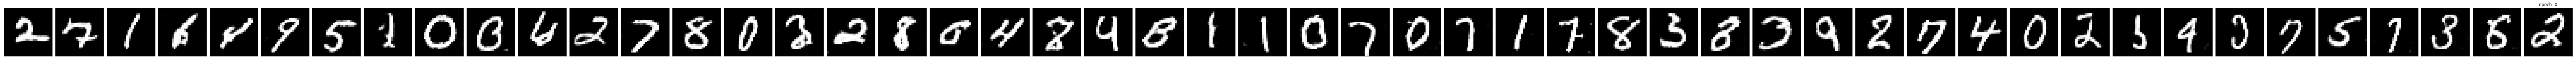

d:0, g:0


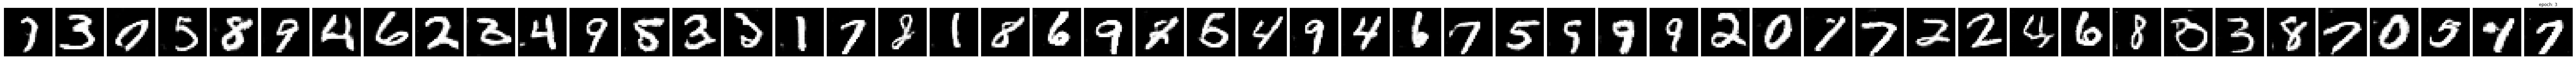

d:0, g:0


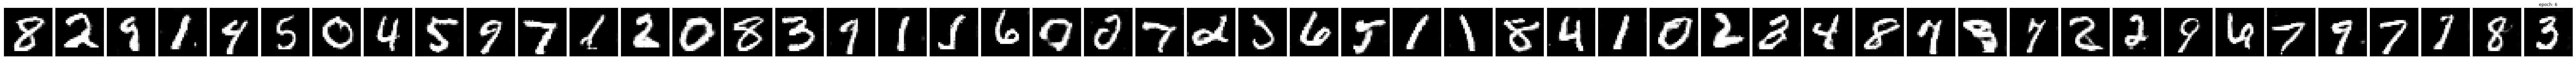

d:0, g:0


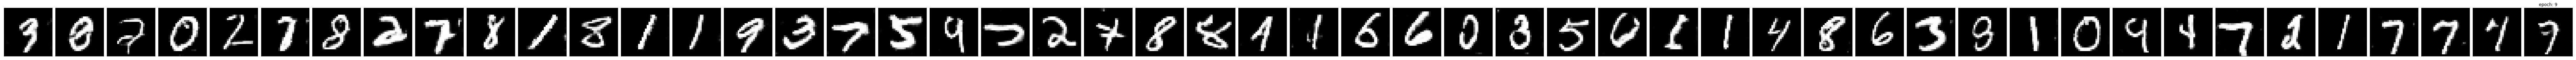

d:0, g:0


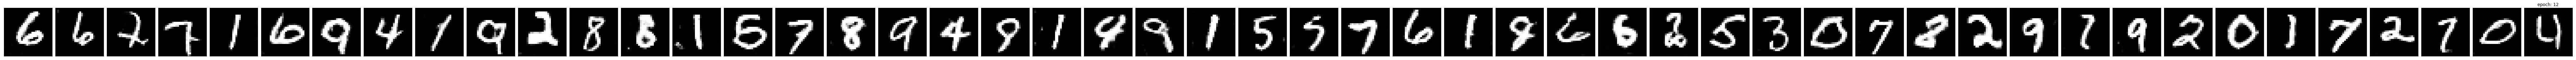

KeyboardInterrupt: 

In [18]:
epochs = 200
batch_size = 50

t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
g_vars = [var for var in t_vars if var.name.startswith('generator')]
saver_disc = tf.train.Saver(d_vars)
saver_gen = tf.train.Saver(g_vars)
saver = tf.train.Saver()

sample_size = 50
losses = []
d_train = True
g_train = True
d_count = 0
g_count = 0
gamma_c = 0

with tf.Session() as sess:
    saver.restore(sess, './checkpoints/generator.ckpt')
    
    for e in range(epochs):
        for i in range(100):
            # get imgs, reshape and rescale to pass to discriminator
            batch = mnist.train.next_batch(batch_size)
            real_imgs = batch[0].reshape(-1, 28, 28, 1)
            real_imgs = real_imgs*2 - 1

            # generate random vector for z 
            rand_noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # update discriminator and generator 
            if d_train:
#                 print("disc training")
                sess.run(d_opt, feed_dict={x:real_imgs, z:rand_noise, gamma:1/(e+1)**3})
            if g_train:
#                 print("gen training")
                sess.run(g_opt, feed_dict={x:real_imgs, z:rand_noise, gamma:1/(e+1)**3})
            
            # save training losses 
            train_loss_d = d_loss.eval({x:real_imgs, z:rand_noise, gamma:0})
            train_loss_g = g_loss.eval({z:rand_noise, gamma:0})
            losses.append((train_loss_d, train_loss_g))
            
#             if train_loss_d > train_loss_g:
#                 d_count += 1
#                 d_train = True
#                 g_train = False
#             else:
#                 g_count += 1
#                 d_train = False
#                 g_train = True
        
        # print generated images 
        if e%3 == 0:
            print("d:{0}, g:{1}".format(d_count, g_count))
            # generate fake images
            sample_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            g_logits, g_imgs = sess.run(generator(z, z_size, reuse=True), feed_dict={z: sample_z, gamma:0})
            
            # plot fake images 
            fig, axes = plt.subplots(1, 50, figsize=(100, 2))
            for index, ax in enumerate(axes):
                ax.imshow(g_imgs[index][:, :, 0], cmap='Greys_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            fig.tight_layout(pad=0.2)
            plt.title("epoch: {0}".format(e))
            plt.show()
    
    # save the trained generator weights
    saver.save(sess, './checkpoints/generator.ckpt')
    saver_disc.save(sess, './checkpoints_disc/only_disc.ckpt')
    saver_gen.save(sess, './checkpoints_gen/only_gen.ckpt')
    

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator", alpha=0.5)
plt.plot(losses.T[1], label="Generator", alpha=0.5)
plt.title("training losses")
plt.legend()
plt.show()

In [ ]:
saver = tf.train.Saver()

with tf.Session() as sess:
    # restore saved model 
    saver.restore(sess, './checkpoints/generator.ckpt')
    
    # generate 50 samples 
    sample_z = np.random.uniform(-1, 1, size=(50, z_size))
    g_logits, g_imgs = sess.run(generator(z, z_size, reuse=True), feed_dict={z: sample_z})

    # plot fake images 
    fig, axes = plt.subplots(5, 10, figsize=(20, 10))
    index = 0
    for row in axes:
        for ax in row:
            ax.imshow(g_imgs[index][:, :, 0], cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            index += 1
    fig.tight_layout(pad=0.2)
    plt.title("epoch: {0}".format(e))
    plt.show()
    